In [1]:
# SimPEG functionality
from simpeg.potential_fields import gravity
from simpeg.utils import plot2Ddata, model_builder, download
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils
)

# discretize functionality
from discretize import TensorMesh, TreeMesh
from discretize.utils import active_from_xyz


# Common Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile
import pathlib
import geopandas as gpd

mpl.rcParams.update({"font.size": 14})

In [2]:
dir_path = pathlib.Path("..") / "data"

In [3]:
# Load topography (xyz file)
topo_xyz = np.loadtxt(dir_path/'topography_table.csv')
# Load field data (xyz file)
dobs = np.loadtxt(dir_path/'obs_data_inv.csv')

In [4]:
xmin = topo_xyz[:,0].min()
xmax = topo_xyz[:,0].max()
ymin = topo_xyz[:,1].min()
ymax = topo_xyz[:,1].max()

In [5]:
data_dir = pathlib.Path("..") / "data"
image_dir = pathlib.Path("..") / "report" / "figures"
shape_dir = pathlib.Path("..") / "data" / "shapefile"

mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

In [6]:
# get the pluton shapefile
pluton = os.path.join(shape_dir/"corrego_seco.shp")
geology = gpd.read_file(pluton)
geology = geology.to_crs("EPSG:32722")

In [7]:
# Get the boundaries of the pluton
bounds = dict(zip(["x_min", "y_min", "x_max", "y_max"], geology.total_bounds))
bounds

{'x_min': 605823.395443203,
 'y_min': 8182055.776986356,
 'x_max': 611485.4164766329,
 'y_max': 8187692.808586231}

## Plot Observed Data and Topography

In [8]:
# Define receiver locations and observed data
receiver_locations = dobs[:, 0:3]
dobs = dobs[:, -1]

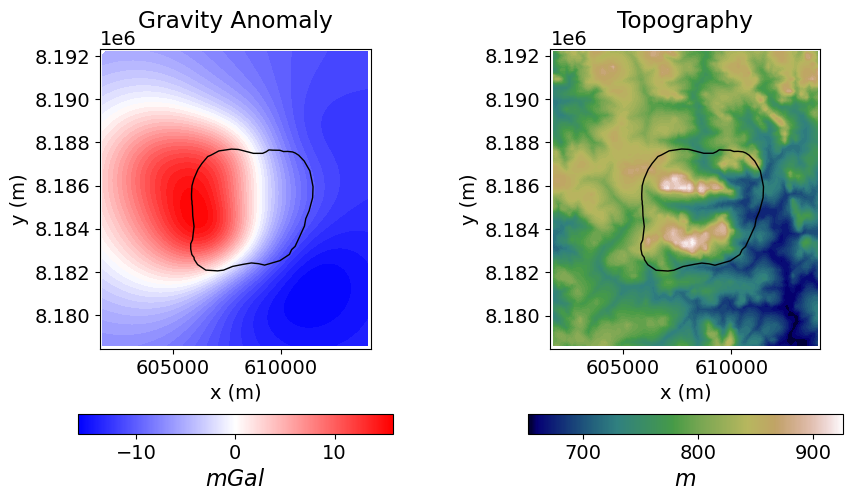

In [9]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_axes([0.05, 0.35, 0.35, 0.6])
plot2Ddata(
    receiver_locations,
    dobs,
    ax=ax1,
    dataloc=False,
    ncontour=40,
    contourOpts={"cmap": "bwr"},
)
ax1.set_title("Gravity Anomaly", pad=15)
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

cx1 = fig.add_axes([0.05, 0.18, 0.35, 0.04])
norm1 = mpl.colors.Normalize(vmin=-np.max(np.abs(dobs)), vmax=np.max(np.abs(dobs)))
cbar1 = mpl.colorbar.ColorbarBase(
    cx1, norm=norm1, orientation="horizontal", cmap=mpl.cm.bwr
)
cbar1.set_label("$mGal$", size=16)
geology.plot(ax=ax1, edgecolor="black", facecolor="none") 

ax2 = fig.add_axes([0.55, 0.35, 0.35, 0.6])
plot2Ddata(
    topo_xyz[:, 0:2],
    topo_xyz[:, -1],
    ax=ax2,
    ncontour=50,
    contourOpts={"cmap": "gist_earth"},
)
ax2.set_title("Topography", pad=15)
ax2.set_xlabel("x (m)")
ax2.set_ylabel("y (m)")

cx2 = fig.add_axes([0.55, 0.18, 0.35, 0.04])
norm2 = mpl.colors.Normalize(vmin=np.min(topo_xyz[:, -1]), vmax=np.max(topo_xyz[:, -1]))
cbar2 = mpl.colorbar.ColorbarBase(
    cx2, norm=norm2, orientation="horizontal", cmap=mpl.cm.gist_earth
)
cbar2.set_label("$m$", size=16)
geology.plot(ax=ax2, edgecolor="black", facecolor="none") 

plt.show()

## Assign Uncertainties

In [10]:
maximum_anomaly = np.max(np.abs(dobs))
floor_uncertainty = 0.01 * maximum_anomaly
uncertainties = floor_uncertainty * np.ones(np.shape(dobs))
print("Floor uncertainty: {}".format(floor_uncertainty))

Floor uncertainty: 0.15875933578750887


## Define the Survey

In [11]:
# Define the receivers. The data consist of vertical gravity anomaly measurements.
# The set of receivers must be defined as a list.
receiver_list = gravity.receivers.Point(receiver_locations, components="gz")
receiver_list = [receiver_list]

# Define the source field
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Define the survey
survey = gravity.survey.Survey(source_field)

## Define the Data

In [12]:
data_object = data.Data(survey, dobs=dobs, standard_deviation=0.01)

## Weighted Least-Squares Inversion on a Tensor Mesh

Here, we provide a step-by-step best-practices approach for weighted least-squares inversion of gravity anomaly data.

### Design a (Tensor) Mesh

Meshes are designed using the [discretize package](https://discretize.simpeg.xyz). Here, we design a [tensor mesh](xref:discretize#discretize.TensorMesh). See the [discretize user tutorials](https://discretize.simpeg.xyz/en/main/tutorials/mesh_generation/index.html) to learn more about creating meshes. When designing a mesh for gravity inversion, we must consider the spatial wavelengths of the signals contained within the data. If the data spacing is large and/or the signals present in the data are smooth, larger cells can be used to construct the mesh. If the data spacing is smaller and compact anomalies are observed, smaller cells are needed to characterize the structures responsible. And smaller cells are required when the effects of surface topography are significant.

**General rule of thumb:** The minimum cell size in each direction is at most 0.5 - 1 times the station spacing. And the thickness of the padding is at least 1 - 2 times the width of the survey region.

In [13]:
# Generate tensor mesh with top at z = 0 m
dh = 250.0  # minimum cell size
hx = [(dh, 5, -1.15), (dh, 30), (dh, 5, 1.15)]  # discretization along x
hy = [(dh, 5, -1.15), (dh, 30), (dh, 5, 1.15)]  # discretization along y
hz = [(dh, 5, -1.2), (dh, 30)]  # discretization along z
tensor_mesh = TensorMesh([hx, hy, hz], "CCN")

# Shift vertically to top same as maximum topography
tensor_mesh.origin += np.r_[609000, 8185000, topo_xyz[:, -1].max()]

In [14]:
# # Generate tensor mesh with top at z = 0 m
# dh = 250.0  # minimum cell size
# hx = [(dh, 5, -1.5), (dh, 60), (dh, 5, 1.5)]  # discretization along x
# hy = [(dh, 5, -1.5), (dh, 60), (dh, 5, 1.5)]  # discretization along y
# hz = [(dh, 0, -1.5), (dh, 30)]  # discretization along z
# tensor_mesh = TensorMesh([hx, hy, hz], "CCN")

# # Shift vertically to top same as maximum topography
# tensor_mesh.origin += np.r_[609000, 8185000, topo_xyz[:, -1].max()]

In [15]:
# Generate tensor mesh with top at z = 0 m
dh = 250.0  # minimum cell size
hx = [(dh, 10, -1.2), (dh, 30), (dh, 10, 1.2)]  # discretization along x
hy = [(dh, 10, -1.2), (dh, 30), (dh, 10, 1.2)]  # discretization along y
hz = [(dh, 7, -1.2), (dh, 30)]  # discretization along z
tensor_mesh = TensorMesh([hx, hy, hz], "CCN")

# Shift vertically to top same as maximum topography
tensor_mesh.origin += np.r_[609000, 8185000, topo_xyz[:, -1].max()]

In [16]:
# Generate tensor mesh with top at z = 0 m
dh = 450.0  # minimum cell size
hx = [(dh, 10, -1.15), (dh, 20), (dh, 10, 1.15)]  # discretization along x
hy = [(dh, 10, -1.15), (dh, 20), (dh, 10, 1.15)]  # discretization along y
hz = [(dh, 5, -1.15), (dh, 20)]  # discretization along z
tensor_mesh = TensorMesh([hx, hy, hz], "CCN")

# Shift vertically to top same as maximum topography
tensor_mesh.origin += np.r_[609000, 8185000, topo_xyz[:, -1].max()]

In [17]:
# # Obter coordenadas do centro das células para TODA a malha
# cell_centers = tensor_mesh.cell_centers
 
# # Separar coordenadas em x, y e z
# x_all, y_all, z_all = cell_centers[:, 0], cell_centers[:, 1], cell_centers[:, 2]


# mask_host =(z_all >= 0) & (z_all <= 1500)


# mask_full = (x_all >= 607000) & (x_all <= 610000) & \
#             (y_all >= 8182000) & (y_all <= 8186000) & \
#             (z_all >= 0) & (z_all <= 926)



In [18]:
tensor_mesh

TensorMesh: 40,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     40    593,992.83    624,007.17    450.00  1,820.50    1.15
   y     40  8,169,992.83  8,200,007.17    450.00  1,820.50    1.15
   z     25    -11,563.18        926.00    450.00    905.11    1.15

### Define the Active Cells

Whereas cells below the Earth's surface contribute towards the simulated gravity anomaly, air cells do not.
The set of mesh cells used in the forward simulation are referred to as 'active cells'. Unused cells (air cells) are 'inactive cells'. Here, the discretize [active_from_xyz](xref:discretize#discretize.utils.active_from_xyz) utility function is used to find the indices of the active cells using the mesh and surface topography. The output quantity is a ``bool`` array.

In [19]:
active_tensor_cells = active_from_xyz(tensor_mesh, topo_xyz)
n_tensor_active = int(active_tensor_cells.sum())

In [20]:

ind_gabbro = (
    (tensor_mesh.gridCC[active_tensor_cells, 0] >= bounds['x_min'] ) & 
    (tensor_mesh.gridCC[active_tensor_cells, 0] <= bounds['x_max'] ) &
    (tensor_mesh.gridCC[active_tensor_cells, 1] >= bounds['y_min']) & 
    (tensor_mesh.gridCC[active_tensor_cells, 1] <= bounds['y_max']) &
    (tensor_mesh.gridCC[active_tensor_cells, 2] >= 400    ) & 
    (tensor_mesh.gridCC[active_tensor_cells, 2] <= 926    )
)


In [21]:
# Definir buffer de 1 km para remover nas bordas do gabro
buffer = 1000
bounds_gabbro = {
    'x_min': bounds['x_min'] + buffer,
    'x_max': bounds['x_max'] - buffer,
    'y_min': bounds['y_min'] + buffer,
    'y_max': bounds['y_max'] - buffer,
}

# Índice para o gabro (região central reduzida)
ind_gabbro = (
    (tensor_mesh.gridCC[active_tensor_cells, 0] >= bounds_gabbro['x_min']) & 
    (tensor_mesh.gridCC[active_tensor_cells, 0] <= bounds_gabbro['x_max']) &
    (tensor_mesh.gridCC[active_tensor_cells, 1] >= bounds_gabbro['y_min']) & 
    (tensor_mesh.gridCC[active_tensor_cells, 1] <= bounds_gabbro['y_max']) &
    (tensor_mesh.gridCC[active_tensor_cells, 2] >= 400) & 
    (tensor_mesh.gridCC[active_tensor_cells, 2] <= 926)  # Mantendo Z inalterado
)

# Índice para o diorito (faixa externa ao redor do gabro, mantendo Z igual)
ind_diorite = (
    (tensor_mesh.gridCC[active_tensor_cells, 0] >= bounds['x_min']) & 
    (tensor_mesh.gridCC[active_tensor_cells, 0] <= bounds['x_max']) &
    (tensor_mesh.gridCC[active_tensor_cells, 1] >= bounds['y_min']) & 
    (tensor_mesh.gridCC[active_tensor_cells, 1] <= bounds['y_max']) &
    (tensor_mesh.gridCC[active_tensor_cells, 2] >= 400) & 
    (tensor_mesh.gridCC[active_tensor_cells, 2] <= 926) &  # Mantendo Z inalterado
    ~ind_gabbro  # Remove a região do gabro, deixando apenas a borda externa
)

### Mapping from the Model to Active Cells

In SimPEG, the term 'model' is not synonymous with the physical property values defined on the mesh. For whatever model we choose, we must define a mapping from the set of model parameters (a [1D numpy.ndarray](xref:numpy#numpy.ndarray)) to the active cells in the mesh. Mappings are created using the [simpeg.maps](xref:simpeg#simpeg.maps.IdentityMap) module. For the tutorial exercise, the model is the density contrast values for all active cells. As such, our mapping is an identity mapping, whose dimensions are equal to the number of active cells.

In [22]:
tensor_model_map = maps.IdentityMap(nP=n_tensor_active)

### Starting/Reference Models

The **starting model** defines a reasonable starting point for the inversion and does not necessarily represent an initial estimate of the true model. Because the integral formulation used to solve the gravity forward simulation is linear, the optimization problem we must solve is a linear least-squares problem, making the choice in starting model insignificant. It should be noted that the starting model **cannot be vector of zeros,** otherwise the inversion will be unable to compute a gradient direction at the first iteration. For gravity inversion, the starting model is frequently a constant vector with a very small value.

The **reference model** is used to include a-prior information. The impact of the reference model on the inversion will be discussed in another tutorial. Assuming the contribution from all background structures has been removed from the gravity anomaly data, and assuming we have not a-priori information, the reference model for basic inversion of gravity data is zero.

Notice that the length of the starting and reference models is equal to the number of active mesh cells!!!

In [23]:
starting_tensor_model = 1e-6 * np.ones(n_tensor_active)
reference_tensor_model = np.zeros_like(starting_tensor_model)

# reference_tensor_model[ind_diorite]=-0.08
reference_tensor_model[ind_gabbro]=-0.22


In [24]:
# starting_tensor_model = 1e-6 * np.ones(n_tensor_active)
# reference_tensor_model = np.zeros_like(starting_tensor_model)
# # pos = np.array(indices_host)[np.array(indices_host) < n_tensor_active]  # Garante que os índices estão dentro dos limites
# # reference_tensor_model[pos] = 0.0
# pos = np.array(indices)[np.array(indices) < n_tensor_active]  # Garante que os índices estão dentro dos limites
# reference_tensor_model[pos] = -0.23


In [25]:
reference_tensor_model.min()

-0.22

In [26]:
# Map for ignoring inactive cells when plotting
tensor_plotting_map = maps.InjectActiveCells(tensor_mesh, active_tensor_cells, np.nan)
np.shape(tensor_plotting_map)

(40000, 39771)

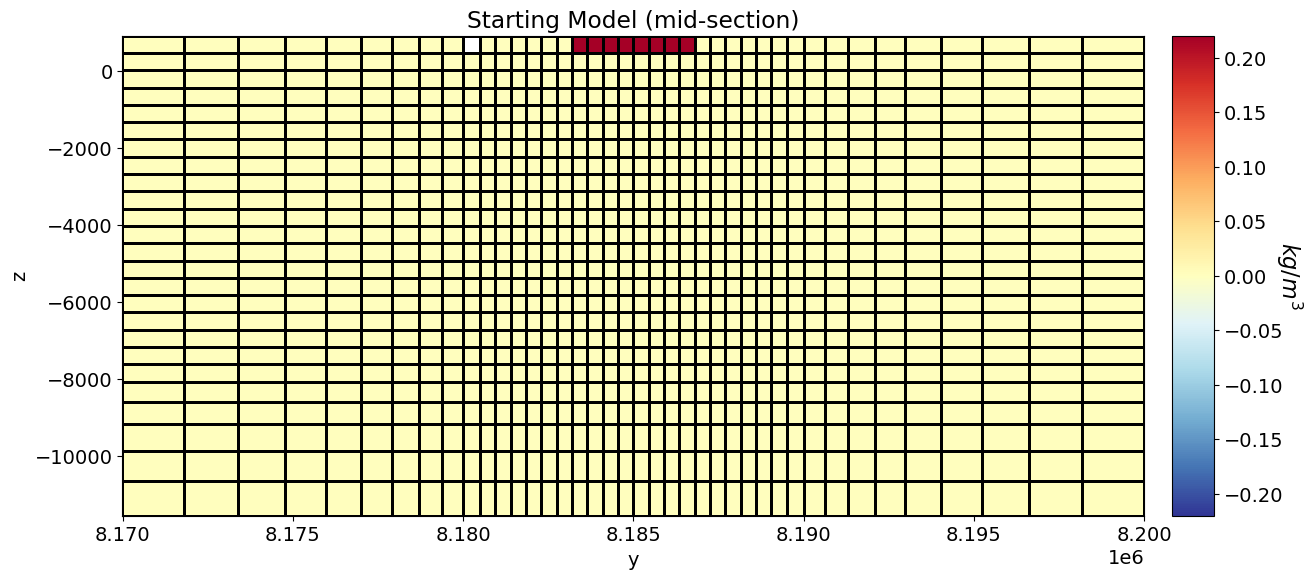

In [27]:
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])


scale = np.max(abs(reference_tensor_model))

norm = mpl.colors.Normalize(vmin=-scale, vmax=scale)
tensor_mesh.plot_slice(
    tensor_plotting_map * reference_tensor_model*-1000,
    normal="X",
    ax=ax1,
    ind=int(tensor_mesh.shape_cells[0] / 2),
    # ind=14,
    grid=True,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)
ax1.set_title("Starting Model (mid-section)")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$kg/m^3$", rotation=270, labelpad=15, size=16)

plt.show()

### Define the Forward Simulation

A simulation object defining the forward problem is required in order to predict data and calculate misfits for recovered models. A comprehensive description of the simulation object for gravity anomaly data was discussed in the [3D Forward Simulation of Gravity Anomaly Data](fwd_gravity_anomaly_3d.ipynb) tutorial. Here, we use the [3D integral formulation](xref:simpeg#simpeg.potential_fields.gravity.simulation.Simulation3DIntegral).

In [28]:
simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=tensor_mesh,
    rhoMap=tensor_model_map,
    active_cells=active_tensor_cells,
    engine="choclo",
)

### Define the Data Misfit

To understand the role of the data misfit in the inversion, please visit [this online resource](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/Uncertainties.html).
Here, we use the [L2DataMisfit](xref:simpeg#simpeg.data_misfit.L2DataMisfit) class to define the data misfit. In this case, the data misfit is the L2 norm of the weighted residual between the observed data and the data predicted for a given model. When instantiating the data misfit object within SimPEG, we must assign an appropriate *data object* and *simulation object* as properties.

In [29]:
dmis = data_misfit.L2DataMisfit(data=data_object, simulation=simulation)

In [30]:
# inversion directives
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)

# Defines the directives for the IRLS regularization. This includes setting
# the cooling schedule for the trade-off parameter.
update_IRLS = directives.UpdateIRLS(
    f_min_change=1e-4,
    max_irls_iterations=30,
    irls_cooling_factor=1.5,
    misfit_tolerance=1e-2,
)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()

# The directives are defined as a list
directives_list = [
    update_IRLS,
    starting_beta,
    save_iteration,
    update_jacobi,
]

# Define the regularization (model objective function) with distance weighting.
reg_dist = regularization.Sparse(tensor_mesh, active_cells=active_tensor_cells, mapping=tensor_model_map)
reg_dist.norms = [2, 1, 1, 1]
# reg_dist.norms = [1, 1, 1, 1]
# reg_dist.norms = [1, 1, 1, 1]
# reg_dist.bounds = (-2.30, +0.70)


distance_weights = utils.distance_weighting(
    tensor_mesh, receiver_locations, active_cells=active_tensor_cells, exponent=1.6
)
reg_dist.set_weights(distance_weights=distance_weights)

# Define how the optimization problem is solved. Here we will use a projected
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(
    maxIter=100, lower=-1.0, upper=1.0, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg_dist, opt)

# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run inversion
recovered_model_dist = inv.run(reference_tensor_model)


Running inversion with SimPEG v0.23.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Mumps and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.69e-01  1.67e+09  3.65e+08  1.73e+09    1.99e+02      0              
   1  8.45e-02  2.80e+07  8.79e+08  1.02e+08    1.96e+02      0              
   2  4.22e-02  9.87e+06  1.03e+09  5.32e+07    1.96e+02      0   Skip BFGS  

### Plot the Data Misfit

This step is necessary for determining whether the recovered model accurately reproduces observed anomalies. Here, we plot the observed data, predicted data for the recovered model, and the misfit. As we can see, the predicted data fits the background somewhat better than the anomalies. As a result, you may reassign smaller uncertainties in these areas and re-run the inversion in order to better fit the anomalies. We will do this for the iteratively reweighted least-squares inversion.

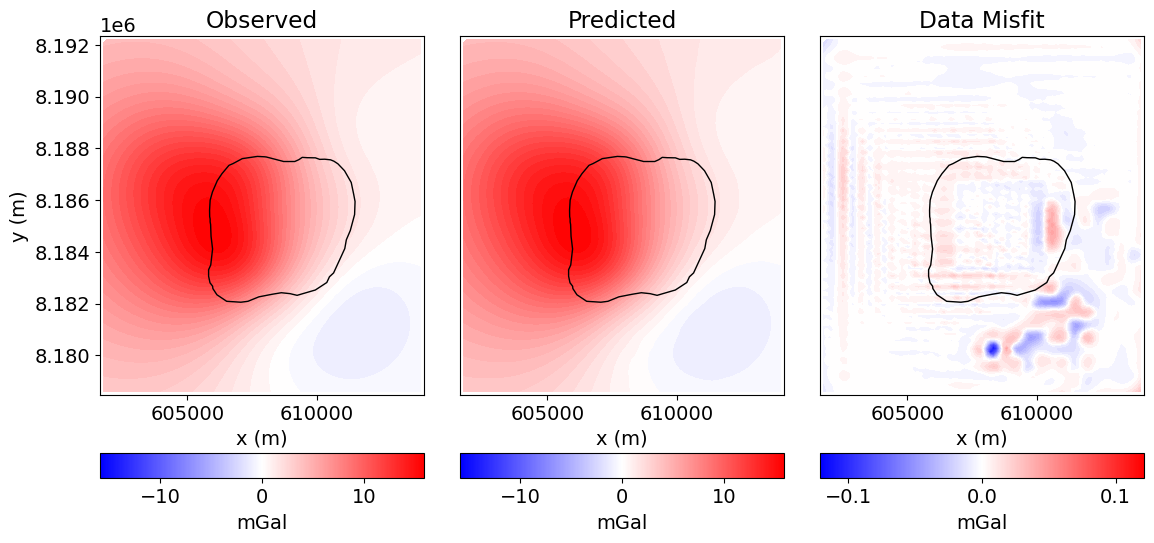

In [31]:
# Predicted data with final recovered model.
dpred = inv_prob.dpred

# Observed data | Predicted data | Data misfit
data_array = np.c_[dobs, dpred, dobs - dpred]

fig = plt.figure(figsize=(12, 5))
plot_title = ["Observed", "Predicted", "Data Misfit"]
plot_units = ["mGal", "mGal", "mGal"]

ax1 = 3 * [None]
ax2 = 3 * [None]
norm = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]
v_lim = [np.max(np.abs(dobs)), np.max(np.abs(dobs)), np.max(np.abs(dobs - dpred))]

for ii in range(0, 3):
    ax1[ii] = fig.add_axes([0.3 * ii + 0.1, 0.2, 0.27, 0.75])
    norm[ii] = mpl.colors.Normalize(vmin=-v_lim[ii], vmax=v_lim[ii])
    cplot[ii] = plot2Ddata(
        receiver_list[0].locations,
        data_array[:, ii],
        ax=ax1[ii],
        ncontour=30,
        contourOpts={"cmap": "bwr", "norm": norm[ii]},
    )
    ax1[ii].set_title(plot_title[ii])
    ax1[ii].set_xlabel("x (m)")
    geology.plot(ax=ax1[ii], edgecolor="black", facecolor="none") 
    if ii == 0:
        ax1[ii].set_ylabel("y (m)")
    else:
        ax1[ii].set_yticks([])

    ax2[ii] = fig.add_axes([0.3 * ii + 0.1, 0.05, 0.27, 0.05])
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm[ii], orientation="horizontal", cmap=mpl.cm.bwr
    )
    cbar[ii].ax.locator_params(nbins=3)
    cbar[ii].set_label(plot_units[ii], labelpad=5)

plt.show()

### Plot the Recovered Model

As we can see, weighted least-squares regularization leads to the recovery of smooth models. And even with sensitivity weighting, there is a tendancy for gravity anomaly inversion to place recovered structures near the Earth's surface.

In [61]:
# # Plot Recovered Model
# coord_x = int(tensor_mesh.cell_centers_x[29])/1000
# print(f"Coordenada do slice no eixo x: {coord_x} km")

coord_x = 607.0  # Coordenada em km que você quer encontrar
coord_x_m = coord_x * 1000  # Converter para metros

# Encontrar o índice do valor mais próximo
index_x = np.argmin(np.abs(tensor_mesh.cell_centers_x - coord_x_m))

print(f"Índice mais próximo: {index_x}")

Índice mais próximo: 15


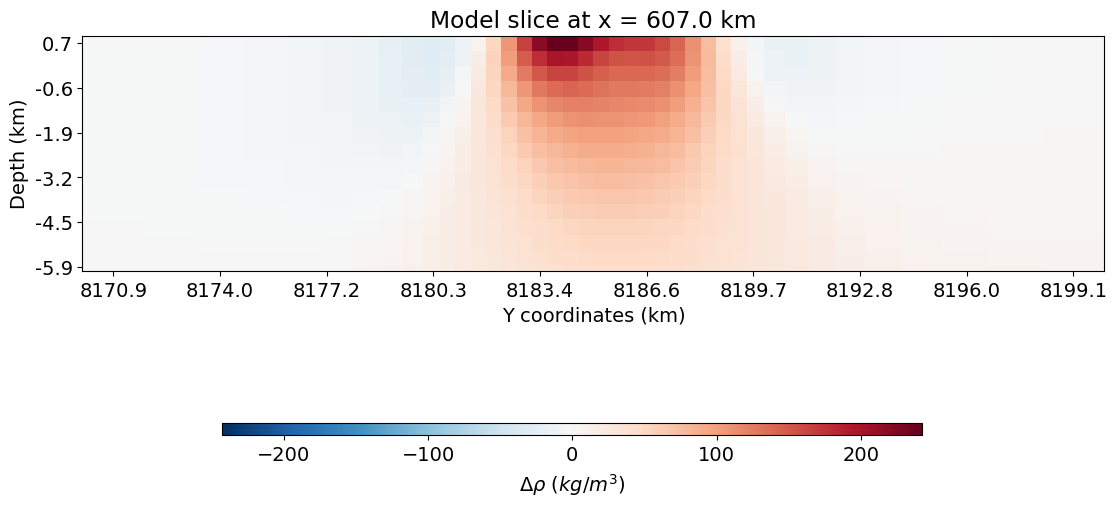

In [62]:
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

scale = np.max(abs(recovered_model_dist))*1000
# scale = 230
norm = mpl.colors.Normalize(
    vmin=-scale, vmax=scale
)
tensor_mesh.plot_slice(
    tensor_plotting_map * recovered_model_dist *-1000,
    normal="X",
    ax=ax1,
    # ind=int(tensor_mesh.shape_cells[0] / 2),
    ind=index_x,
    grid=False,
    # pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
    pcolor_opts={"cmap": mpl.cm.RdBu_r, "norm": norm},

)
ax1.set_title(f"Model slice at x = {coord_x} km")


# Definir os limites dos eixos com base no modelo
x_min, x_max = tensor_mesh.cell_centers_y.min(), tensor_mesh.cell_centers_y.max()
y_min, y_max = tensor_mesh.cell_centers_z.min(), tensor_mesh.cell_centers_z.max()  # Assumindo profundidade no eixo Z

# Criar os ticks dentro dos limites do modelo
x_ticks = np.linspace(x_min, x_max, num=10)  # Ajuste 'num' conforme necessário
y_ticks = np.linspace(y_min, y_max, num=10)

# Ajustar os ticks e rótulos no formato de km
ax1.set_xticks(x_ticks)
ax1.set_xticklabels([f"{tick / 1000:.1f}" for tick in x_ticks])
ax1.set_yticks(y_ticks)
ax1.set_yticklabels([f"{tick / 1000:.1f}" for tick in y_ticks])

ax1.set_aspect('equal')
ax1.set_ylim(-6000, 926)
# ax1.set_xlim(ymin, ymax)

ax1.set_xlabel("Y coordinates (km)")
ax1.set_ylabel("Depth (km)")


# ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
ax2 = fig.add_axes([0.2, 0.03, 0.5, 0.02])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="horizontal", cmap=mpl.cm.RdBu_r #cmap=mpl.cm.RdYlBu_r
)
cbar.set_label(r"$\Delta \rho~(kg/m^3$)", rotation=0, labelpad=5, size=14)
plt.show()

In [63]:
# # Plot Recovered Model
# coord_x = int(tensor_mesh.cell_centers_x[30])/1000
# print(f"Coordenada do slice no eixo x: {coord_x} km")

coord_x2 = 609  # Coordenada em km que você quer encontrar
coord_x_m= coord_x2 * 1000  # Converter para metros

# Encontrar o índice do valor mais próximo
index_x2 = np.argmin(np.abs(tensor_mesh.cell_centers_x - coord_x_m))
print(f"Índice mais próximo: {index_x}")

Índice mais próximo: 15


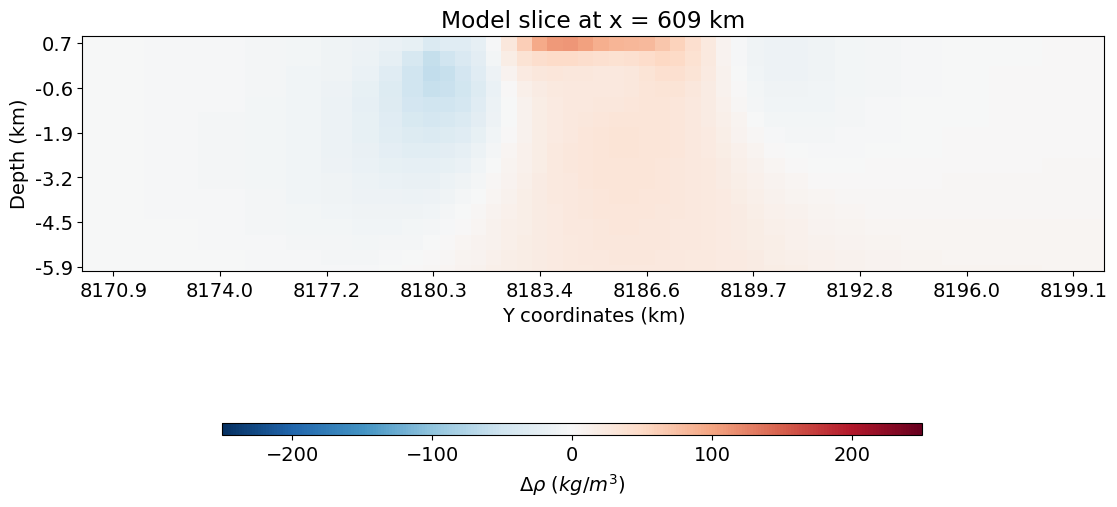

In [64]:
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

scale = np.max(abs(recovered_model_dist))*1000
scale=250
norm = mpl.colors.Normalize(
    vmin=-scale, vmax=scale
)
tensor_mesh.plot_slice(
    tensor_plotting_map * recovered_model_dist *-1000,
    normal="X",
    ax=ax1,
    # ind=int(tensor_mesh.shape_cells[0] / 2),
    ind=index_x2,
    grid=False,
    # pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
    pcolor_opts={"cmap": mpl.cm.RdBu_r, "norm": norm},

)
ax1.set_title(f"Model slice at x = {coord_x2} km")


# Definir os limites dos eixos com base no modelo
x_min, x_max = tensor_mesh.cell_centers_y.min(), tensor_mesh.cell_centers_y.max()
y_min, y_max = tensor_mesh.cell_centers_z.min(), tensor_mesh.cell_centers_z.max()  # Assumindo profundidade no eixo Z

# Criar os ticks dentro dos limites do modelo
x_ticks = np.linspace(x_min, x_max, num=10)  # Ajuste 'num' conforme necessário
y_ticks = np.linspace(y_min, y_max, num=10)

# Ajustar os ticks e rótulos no formato de km
ax1.set_xticks(x_ticks)
ax1.set_xticklabels([f"{tick / 1000:.1f}" for tick in x_ticks])
ax1.set_yticks(y_ticks)
ax1.set_yticklabels([f"{tick / 1000:.1f}" for tick in y_ticks])

ax1.set_aspect('equal')
ax1.set_ylim(-6000, 926)
ax1.set_xlabel("Y coordinates (km)")
ax1.set_ylabel("Depth (km)")


# ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
ax2 = fig.add_axes([0.2, 0.03, 0.5, 0.02])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="horizontal", cmap=mpl.cm.RdBu_r #cmap=mpl.cm.RdYlBu_r
)
cbar.set_label(r"$\Delta \rho~(kg/m^3$)", rotation=0, labelpad=5, size=14)
plt.show()

In [65]:
# # Plot Recovered Model
# coord_y = int(tensor_mesh.cell_centers_y[46])/1000
# print(f"Coordenada do slice no eixo Y: {coord_y} km")

coord_y = 8185  # Coordenada em km que você quer encontrar
coord_y_m = coord_y * 1000  # Converter para metros

# Encontrar o índice do valor mais próximo
index_y = np.argmin(np.abs(tensor_mesh.cell_centers_y - coord_y_m))
print(f"Índice mais próximo: {index_y}")

Índice mais próximo: 19


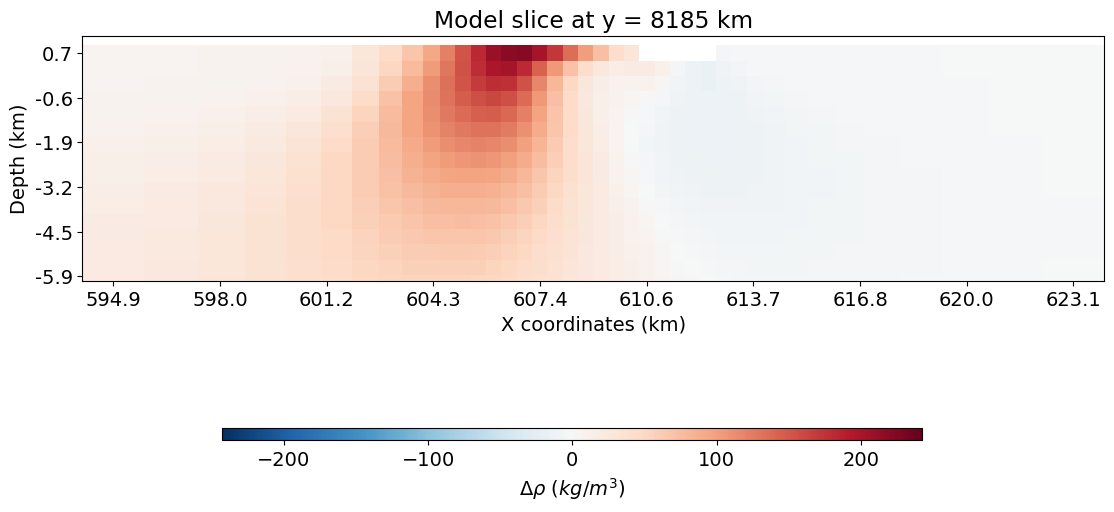

In [66]:
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

scale = np.max(abs(recovered_model_dist))*1000
# scale =230
norm = mpl.colors.Normalize(
    vmin=-scale, vmax=scale
)
tensor_mesh.plot_slice(
    tensor_plotting_map * recovered_model_dist *-1000,
    normal="Y",
    ax=ax1,
    # ind=int(tensor_mesh.shape_cells[0] / 2),
    ind=index_y,
    grid=False,
    # pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
    pcolor_opts={"cmap": mpl.cm.RdBu_r, "norm": norm},

)
# Definir os limites dos eixos com base no modelo
x_min, x_max = tensor_mesh.cell_centers_x.min(), tensor_mesh.cell_centers_x.max()
y_min, y_max = tensor_mesh.cell_centers_z.min(), tensor_mesh.cell_centers_z.max()  # Assumindo profundidade no eixo Z

# Criar os ticks dentro dos limites do modelo
x_ticks = np.linspace(x_min, x_max, num=10)  # Ajuste 'num' conforme necessário
y_ticks = np.linspace(y_min, y_max, num=10)

# Ajustar os ticks e rótulos no formato de km
ax1.set_xticks(x_ticks)
ax1.set_xticklabels([f"{tick / 1000:.1f}" for tick in x_ticks])
ax1.set_yticks(y_ticks)
ax1.set_yticklabels([f"{tick / 1000:.1f}" for tick in y_ticks])

ax1.set_xlabel("X coordinates (km)")
ax1.set_ylabel("Depth (km)")
ax1.set_title(f"Model slice at y = {coord_y} km")
ax1.set_aspect('equal')
ax1.set_ylim(-6000, 1200)
# ax1.set_xlim(xmin, xmax)

# ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
ax2 = fig.add_axes([0.2, 0.03, 0.5, 0.02])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="horizontal", cmap=mpl.cm.RdBu_r #cmap=mpl.cm.RdYlBu_r
)


cbar.set_label(r"$\Delta \rho~(kg/m^3$)", rotation=0, labelpad=5, size=14)
plt.show()

In [67]:
# Compute normalized data misfits
normalized_data_misfits = (dobs - dpred) / uncertainties

In [68]:
tensor_mesh.shape_cells[0]

40

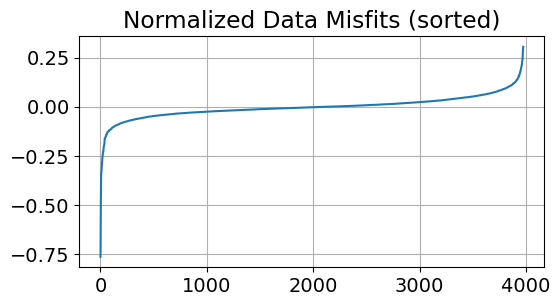

In [69]:
# Plot the normalized data misfits
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.plot(np.sort(normalized_data_misfits))
ax.set_title("Normalized Data Misfits (sorted)")
ax.grid()
plt.show(fig)

# Make paper's images

In [201]:
def calculate_r2(observed, predicted):
    # Calculating the total sum of squares (SST)
    ss_total = np.sum((observed - np.mean(observed))**2)
    
    # Calculating the sum of squared residuals (SSE)
    ss_residual = np.sum((observed - predicted)**2)
    
    # Calculating R²
    r2 = 1 - (ss_residual / ss_total)
    
    return r2

# Example usage
observed = dobs  # Replace with your observed data
predicted = dpred  # Replace with your predicted data

# Calculate R²
r2_value = calculate_r2(observed, predicted)
print(f"The coefficient of determination (R²) is: {r2_value}")


The coefficient of determination (R²) is: 0.9999958327970022


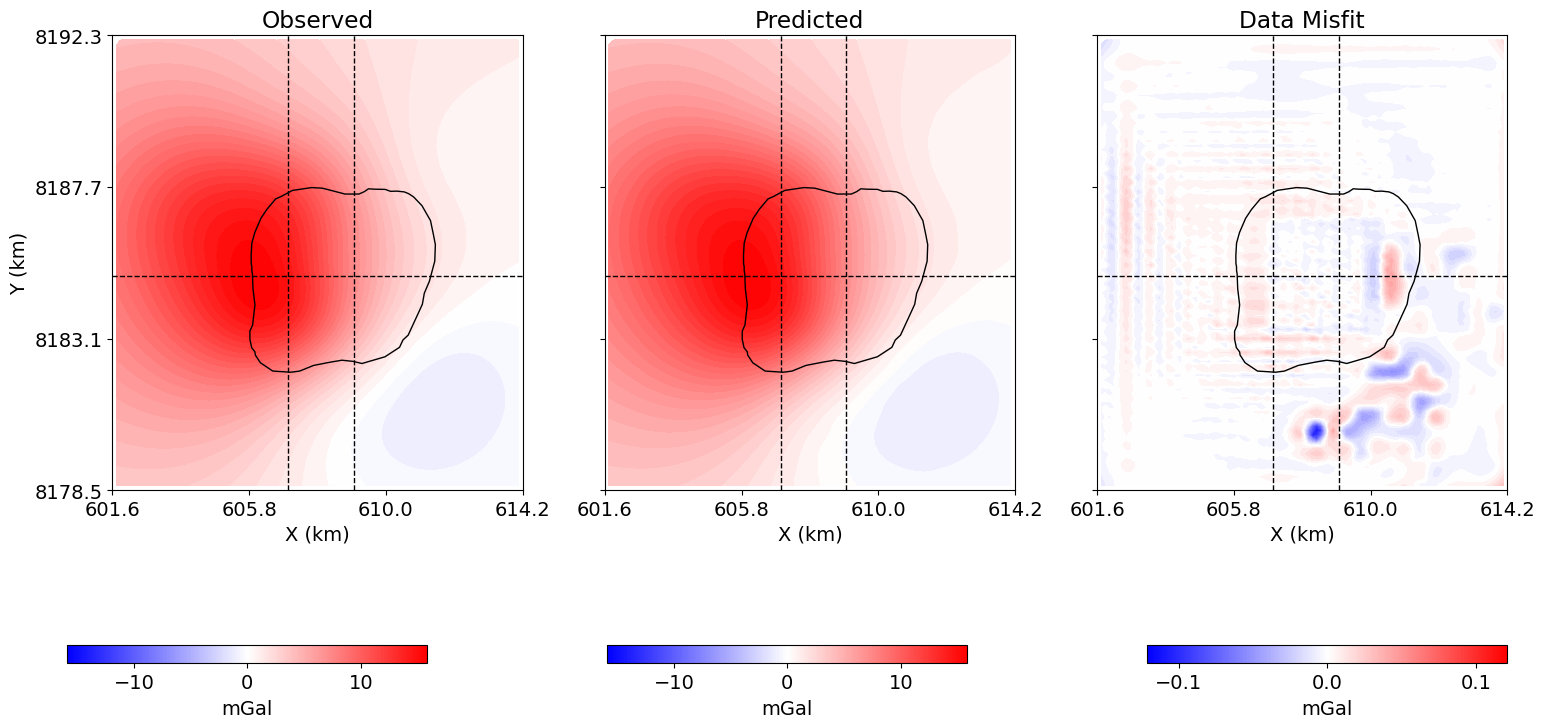

In [239]:
# Observed data | Predicted data | Data misfit
data_array = np.c_[dobs, dpred, dobs - dpred]

fig, ax1 = plt.subplots(1, 3, figsize=(18, 9), sharey=True)  # Added sharey=True here
plot_title = ["Observed", "Predicted", rf"Data Misfit"]
plot_units = ["mGal", "mGal", "mGal"]

norm = [None] * 3
cbar = [None] * 3
cplot = [None] * 3
v_lim = [np.max(np.abs(dobs)), np.max(np.abs(dobs)), np.max(np.abs(dobs - dpred))]

for ii in range(3):
    norm[ii] = mpl.colors.Normalize(vmin=-v_lim[ii], vmax=v_lim[ii])
    cplot[ii] = plot2Ddata(
        receiver_list[0].locations, 
        data_array[:, ii],
        ax=ax1[ii],
        ncontour=30,
        contourOpts={"cmap": "bwr", "norm": norm[ii]},
    )
    ax1[ii].set_title(plot_title[ii])
    ax1[ii].set_xlabel("X (km)")  # Atualizado para km
    geology.plot(ax=ax1[ii], edgecolor="black", facecolor="none")
    ax1[ii].set_aspect('equal')

    if ii == 0:
        ax1[ii].set_ylabel("Y (km)")  # Atualizado para km
    else:
        ax1[ii].set_yticks([])

    # Adicionando as linhas dos perfis
    ax1[ii].hlines(8185 * 1000, receiver_locations_km[:, 0].min(), receiver_locations_km[:, 0].max(), 
                   colors="black", linestyles="dashed", linewidth=1)  # Linha horizontal (perfil Y)
    
    ax1[ii].vlines(607 * 1000, receiver_locations_km[:, 1].min(), receiver_locations_km[:, 1].max(), 
                   colors="black", linestyles="dashed", linewidth=1)  # Primeira linha vertical (perfil X)
    
    ax1[ii].vlines(609 * 1000, receiver_locations_km[:, 1].min(), receiver_locations_km[:, 1].max(), 
                   colors="black", linestyles="dashed", linewidth=1)  # Segunda linha vertical (perfil X)

    # Definir os limites dos eixos com base no modelo
    x_min, x_max = receiver_locations_km[:, 0].min(), receiver_locations_km[:, 0].max()
    y_min, y_max = receiver_locations_km[:, 1].min(), receiver_locations_km[:, 1].max() 
    
    # Criar os ticks dentro dos limites do modelo
    x_ticks = np.linspace(x_min, x_max, num=4)  # Ajuste 'num' conforme necessário
    y_ticks = np.linspace(y_min, y_max, num=4)
    
    # Ajustar os ticks e rótulos no formato de km
    ax1[ii].set_xticks(x_ticks)
    ax1[ii].set_xticklabels([f"{tick / 1000:.1f}" for tick in x_ticks])
    ax1[ii].set_yticks(y_ticks)
    ax1[ii].set_yticklabels([f"{tick / 1000:.1f}" for tick in y_ticks])
        
    ax2 = fig.add_axes([0.3 * ii + 0.1, 0.05, 0.2, 0.02])
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2, norm=norm[ii], orientation="horizontal", cmap=mpl.cm.bwr
    )
    cbar[ii].ax.locator_params(nbins=3)
    cbar[ii].set_label(plot_units[ii], labelpad=5)

plt.show()


/tmp/ipykernel_7208/2458929994.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


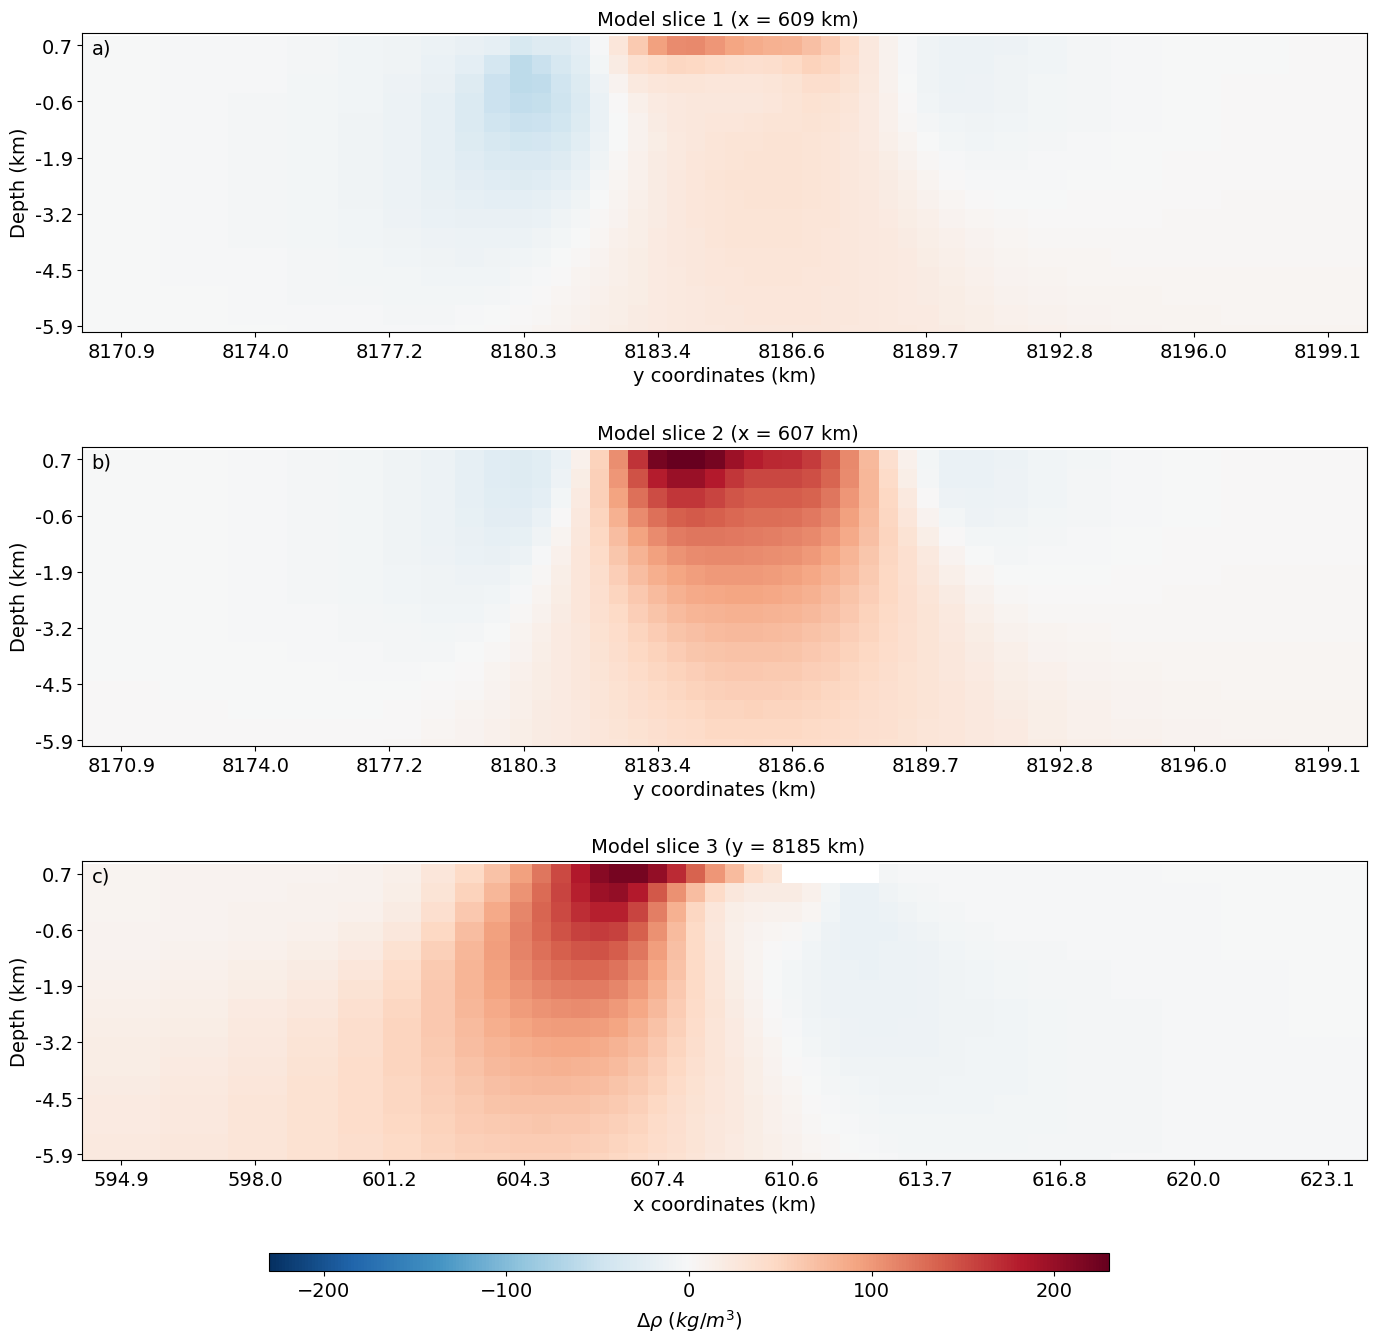

In [247]:
scale = np.max(abs(recovered_model_dist)) * 1000
scale = 230
norm = mpl.colors.Normalize(vmin=-scale, vmax=scale)
cmap = mpl.cm.RdBu_r  # Mapa de cores

fig, axes = plt.subplots(3, 1, figsize=(14, 18))

# Ajustar a distância vertical entre os subplots
fig.subplots_adjust(hspace=-0.7)  # Reduzindo hspace para aproximar os subplots

# Lista de slices e eixos corretos
slices = [
    ("X", "a", 1, 609, tensor_mesh.cell_centers_x, "y coordinates (km)"),
    ("X", "b", 2, 607, tensor_mesh.cell_centers_x, "y coordinates (km)"),
    ("Y", "c", 3, 8185, tensor_mesh.cell_centers_y, "x coordinates (km)")
]

for ax, (normal, letter, slice_number, coord, cell_centers, xlabel) in zip(axes, slices):
    coord_m = coord * 1000  # Converter para metros
    index = np.argmin(np.abs(cell_centers - coord_m))

    tensor_mesh.plot_slice(
        tensor_plotting_map * recovered_model_dist * -1000,
        normal=normal, ax=ax, ind=index, grid=False,
        pcolor_opts={"cmap": cmap, "norm": norm}
    )

    ax.set_title(f" Model slice {slice_number} ({normal.lower()} = {coord} km)", fontsize=14)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Depth (km)")
    ax.set_aspect('equal')

    # Ajustar os limites corretamente dependendo da normal
    if normal == "X":
        x_min, x_max = tensor_mesh.cell_centers_y.min(), tensor_mesh.cell_centers_y.max()
    elif normal == "Y":
        x_min, x_max = tensor_mesh.cell_centers_x.min(), tensor_mesh.cell_centers_x.max()

    y_min, y_max = tensor_mesh.cell_centers_z.min(), tensor_mesh.cell_centers_z.max()

    # Criar os ticks dentro dos limites do modelo
    x_ticks = np.linspace(x_min, x_max, num=10)
    y_ticks = np.linspace(y_min, y_max, num=10)

    # Ajustar os ticks e rótulos no formato de km
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([f"{tick / 1000:.1f}" for tick in x_ticks])
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f"{tick / 1000:.1f}" for tick in y_ticks])
    ax.set_ylim(-6000, 1000)
    ax.text(x_min-700, y_max-200, f"{letter})", fontsize=14)

# Adicionar uma única barra de cores para todos os subplots
cax = fig.add_axes([0.2, 0.125, 0.6, 0.01])  # Ajustar posição
cbar = mpl.colorbar.ColorbarBase(cax, norm=norm, orientation="horizontal", cmap=cmap)
cbar.set_label(r"$\Delta \rho~(kg/m^3)$", rotation=0, labelpad=5, size=14)
plt.tight_layout()
fig.savefig(image_dir/'model_profiles.png', dpi=300)
plt.show()


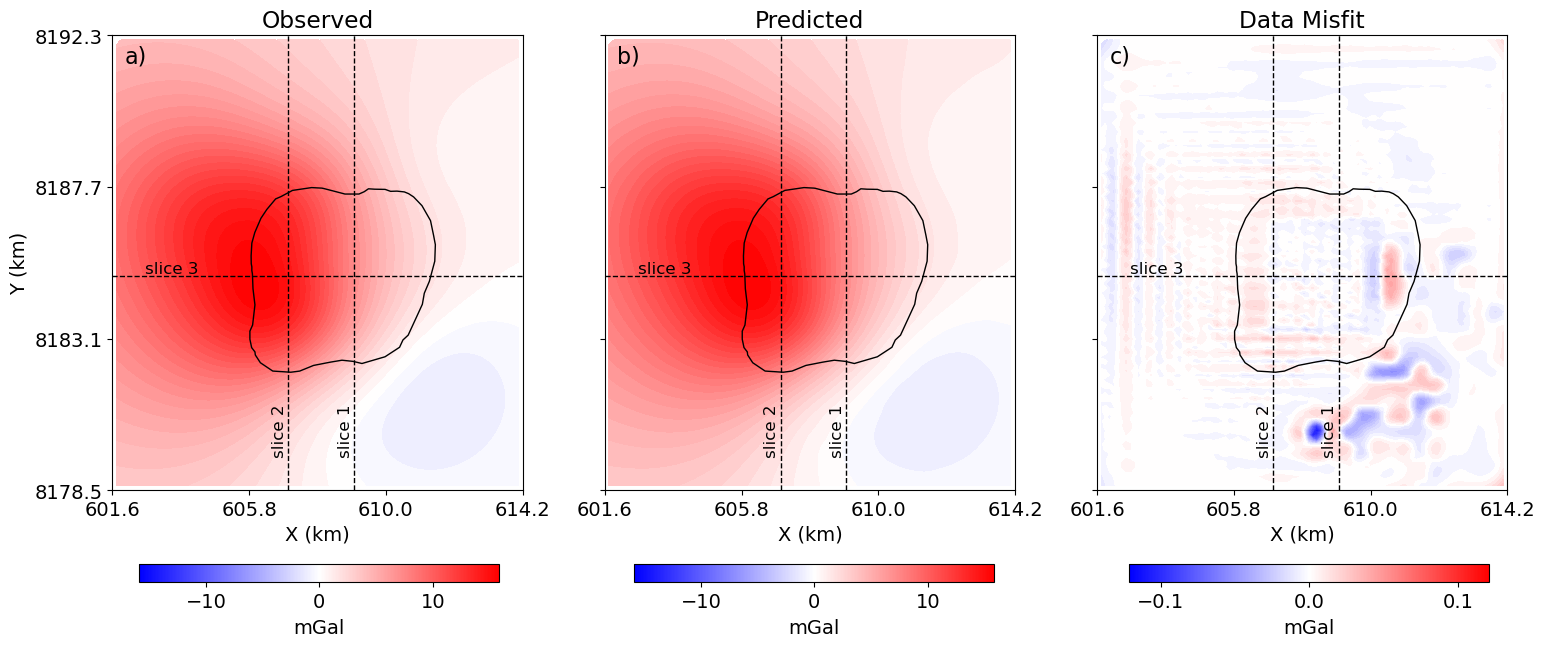

In [292]:
# Observed data | Predicted data | Data misfit
data_array = np.c_[dobs, dpred, dobs - dpred]

fig, ax1 = plt.subplots(1, 3, figsize=(18, 9), sharey=True)  # Added sharey=True here
plot_title = ["Observed", "Predicted", rf"Data Misfit"]
plot_units = ["mGal", "mGal", "mGal"]

norm = [None] * 3
cbar = [None] * 3
cplot = [None] * 3
v_lim = [np.max(np.abs(dobs)), np.max(np.abs(dobs)), np.max(np.abs(dobs - dpred))]

# Nomes dos perfis
profile_labels = ["slice 3", "slice 2", "slice 1"]

colorbar_positions = [
    [0.14, 0.14, 0.2, 0.02],  # Posição para o primeiro gráfico
    [0.415, 0.14, 0.2, 0.02],  # Posição para o segundo gráfico
    [0.69, 0.14, 0.2, 0.02],  # Posição para o terceiro gráfico
]


for ii in range(3):
    norm[ii] = mpl.colors.Normalize(vmin=-v_lim[ii], vmax=v_lim[ii])
    cplot[ii] = plot2Ddata(
        receiver_list[0].locations, 
        data_array[:, ii],
        ax=ax1[ii],
        ncontour=30,
        contourOpts={"cmap": "bwr", "norm": norm[ii]},
    )
    ax1[ii].set_title(plot_title[ii])
    ax1[ii].set_xlabel("X (km)")  # Atualizado para km
    geology.plot(ax=ax1[ii], edgecolor="black", facecolor="none")
    ax1[ii].set_aspect('equal')

    if ii == 0:
        ax1[ii].set_ylabel("Y (km)")  # Atualizado para km
    else:
        ax1[ii].set_yticks([])

    # Adicionando as linhas dos perfis
    ax1[ii].hlines(8185 * 1000, receiver_locations_km[:, 0].min(), receiver_locations_km[:, 0].max(), 
                   colors="black", linestyles="dashed", linewidth=1)  # Linha horizontal (perfil Y)
    ax1[ii].vlines(607 * 1000, receiver_locations_km[:, 1].min(), receiver_locations_km[:, 1].max(), 
                   colors="black", linestyles="dashed", linewidth=1)  # Primeira linha vertical (perfil X)
    ax1[ii].vlines(609 * 1000, receiver_locations_km[:, 1].min(), receiver_locations_km[:, 1].max(), 
                   colors="black", linestyles="dashed", linewidth=1)  # Segunda linha vertical (perfil X)

    # Adicionando os nomes dos perfis perto das linhas
    ax1[ii].text(receiver_locations_km[:, 0].min() + 1000, 8185 * 1000, profile_labels[0], 
                 color='black', fontsize=12, verticalalignment='bottom', horizontalalignment='left')
    
    # Para as linhas verticais, agora o texto está rotacionado para ficar vertical
    ax1[ii].text(607 * 1000-500, receiver_locations_km[:, 1].min() + 1000, profile_labels[1], 
                 color='black', fontsize=12, verticalalignment='bottom', horizontalalignment='left', rotation=90)
    
    ax1[ii].text(609 * 1000-500, receiver_locations_km[:, 1].min() + 1000, profile_labels[2], 
                 color='black', fontsize=12, verticalalignment='bottom', horizontalalignment='left', rotation=90)

    # Definir os limites dos eixos com base no modelo
    x_min, x_max = receiver_locations_km[:, 0].min(), receiver_locations_km[:, 0].max()
    y_min, y_max = receiver_locations_km[:, 1].min(), receiver_locations_km[:, 1].max() 
    
    # Criar os ticks dentro dos limites do modelo
    x_ticks = np.linspace(x_min, x_max, num=4)  # Ajuste 'num' conforme necessário
    y_ticks = np.linspace(y_min, y_max, num=4)
    
    # Ajustar os ticks e rótulos no formato de km
    ax1[ii].set_xticks(x_ticks)
    ax1[ii].set_xticklabels([f"{tick / 1000:.1f}" for tick in x_ticks])
    ax1[ii].set_yticks(y_ticks)
    ax1[ii].set_yticklabels([f"{tick / 1000:.1f}" for tick in y_ticks])
    
    # Adicionando as letras a, b, c no canto superior esquerdo de cada painel
    ax1[ii].text(0.03, 0.98, f"{chr(97 + ii)})", transform=ax1[ii].transAxes, fontsize=16, 
                 verticalalignment='top', horizontalalignment='left', color='black')

    ax2 = fig.add_axes(colorbar_positions[ii])
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2, norm=norm[ii], orientation="horizontal", cmap=mpl.cm.bwr
    )
    cbar[ii].ax.locator_params(nbins=3)
    cbar[ii].set_label(plot_units[ii], labelpad=5)
    
fig.savefig(image_dir/'model_comparison.png', dpi=300)
plt.show()
